# Lorenzo Menchini, matricola 615580. 
# algoritmo di Shor con N=21.
 Introduzione all'Algoritmo di Shor per la Fattorizzazione
# Introduction to Shor's Algorithm for Factorization

This notebook implements Shor's algorithm, a groundbreaking quantum algorithm capable of factoring large integers in polynomial time. This capability contrasts with the exponential difficulty that classical computers face for the same problem, which underpins the security of many current cryptographic systems like RSA.

Shor's algorithm operates in two main phases:

1.  **Classical Problem Reduction:** This phase transforms the problem of factoring a composite number $N$ into the problem of finding the period $r$ of a modular function. Given a random integer $a$ coprime to $N$, we consider the function:
    $$f(x) = a^x \mod{N}$$
    The goal becomes finding the smallest positive integer $r$ such that $a^r \equiv 1 \pmod{N}$.

2.  **Quantum Period Finding:** This phase leverages a quantum computer to efficiently find the period $r$ of the function $f(x)$. The core of this phase is the application of the Quantum Fourier Transform (QFT) to a quantum state that encodes the values of the function.

Once the period $r$ is obtained, if $r$ is even and $a^{r/2} \not\equiv -1 \pmod{N}$, then the factors of $N$ can be found by calculating the greatest common divisor (GCD):
$$\text{factors of } N = \text{GCD}(N, a^{r/2} - 1) \text{ and } \text{GCD}(N, a^{r/2} + 1)$$

This notebook will explore the implementation of each of these phases, culminating in the factorization of an integer through the simulation of Shor's algorithm.

In [28]:
# !pip install qiskit
# !pip install numpy
# !pip install matplotlib
# !pip install fractions
# !pip install --upgrade qiskit
# !pip install pylatexenc
# !pip install qiskit-aer
# !pip install qiskit-ibm-runtime

In [29]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from math import gcd
from fractions import Fraction
import numpy as np

# Initialization of Parameters for Shor's Algorithm

This cell initializes the fundamental parameters required for running Shor's algorithm on the target number $N = 21$. We will explore the algorithm's behavior for three different values of $a$ that are coprime to $N$.

The parameters defined below are:

* `N_value`: This variable stores the composite number we aim to factorize, which is set to 21.
* `N_WORKING_QUBITS`: This determines the number of qubits used in the working register to represent the input $x$ for the modular exponentiation $a^x \mod{N}$. With 5 qubits, we can represent numbers from 0 to $2^5 - 1 = 31$, which is sufficient for our calculations modulo 21.
* `N_PHASE_ESTIMATION_QUBITS`: This specifies the number of qubits used in the phase estimation register. These qubits are crucial for determining the frequency (and hence the period) of the modular exponentiation. A higher number of phase estimation qubits leads to a more precise estimation of the phase. Here, we use 10 qubits, providing a precision up to $2^{-10}$.
* `a`: This is a list containing three different integer values: 2, 10, and 19. For Shor's algorithm to work correctly, the chosen value of $a$ must be coprime with $N$. We will run the core quantum part of the algorithm for each of these $a$ values to observe the period finding process and the subsequent factor extraction.

In [ ]:
N_value = 21
N_WORKING_QUBITS = 5 # 2^5 = 32, which is enough for 21 
N_PHASE_ESTIMATION_QUBITS = 10 # precision up tp 2^-10
a = [2, 10, 19] # 4, 10, 19 values chosen for the project

# Classical Period Finding and Visualization

This cell explores the behavior of the modular exponentiation function $f(x) = a^x \mod{N}$ classically for each of the chosen values of $a$ (2, 10, and 19) with $N = 21$. By plotting the function's output for $x$ ranging from 0 to $N-1$, we can visually inspect for any periodic behavior.

For each value of $a$ in the list `a`:

1.  We generate a range of $x$ values from 0 to $N-1$.
2.  We calculate the corresponding $y$ values using the modular exponentiation: $y = a^x \mod{N}$.
3.  We create a plot showing $x$ on the horizontal axis and $a^x \mod{N}$ on the vertical axis. Each plot is labeled with the specific value of $a$.
4.  We attempt to classically find the period $r$, which is the smallest positive integer such that $a^r \equiv 1 \pmod{N}$. This is done by searching for the first occurrence of the value 1 in the sequence of $y$ values (excluding the first element at $x=0$, where $a^0 \mod{N}$ is always 1 if $a \neq 0$). If a period $r$ is found within the range, it is annotated on the plot.
5.  If the value 1 is not found (indicating no clear period within the plotted range, possibly due to $a$ not being coprime with $N$ or the period being larger than $N$), a message is printed.

This classical analysis helps us understand the periodic nature of the function we aim to analyze quantumly in the subsequent steps of Shor's algorithm. The period $r$ found here will be the target that the quantum phase estimation part of the algorithm aims to determine.

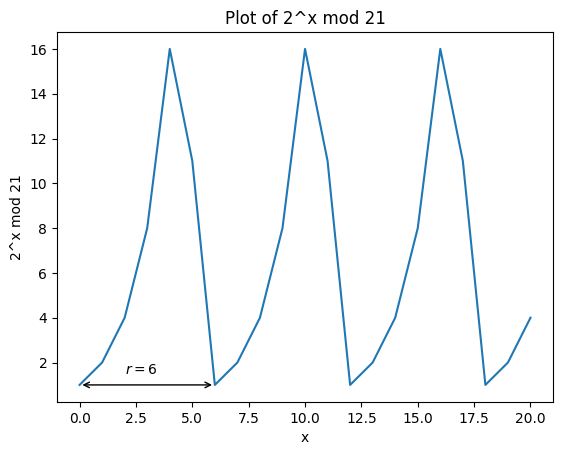

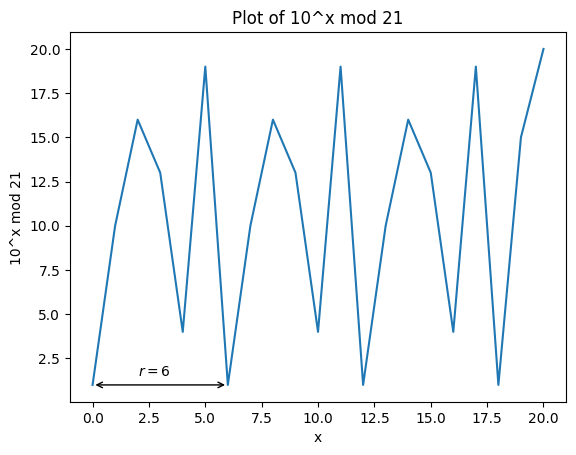

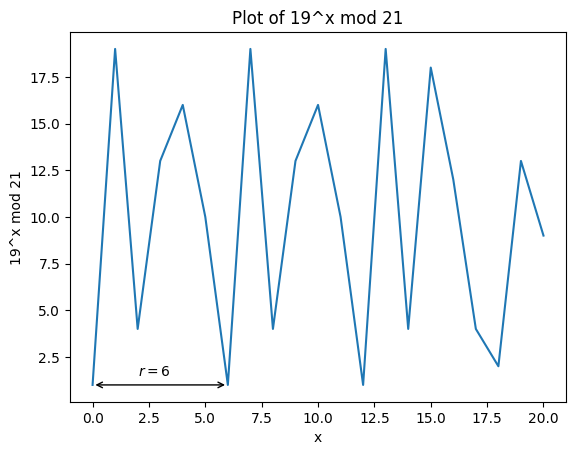

In [31]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(a)):
    xval = np.arange(N_value)
    yvals = [np.mod(a[i]**x, N_value) for x in xval]

    fig, ax = plt.subplots()
    ax.plot(xval, yvals, label=f'a = {a[i]}')
    ax.set_xlabel('x')
    ax.set_ylabel(f'{a[i]}^x mod {N_value}')
    ax.set_title(f'Plot of {a[i]}^x mod {N_value}')

    try:
        r = yvals[1:].index(1) + 1
        plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
        plt.annotate(f'$r={r}$', xy=(r/3,1.5))
    except ValueError:
        print('Could not find period, check a < N and have no common factors.')


As we saw above, for N = 21 we obtain a period r = 6. 
now its time to explore the quantum algorithm. firstly we have to create the U matrix 


# Definition of the Controlled Modular Exponentiation Gate

This cell defines a crucial component for the quantum part of Shor's algorithm: the controlled modular exponentiation gate. This gate implements the operation $|y\rangle \rightarrow |a^x y \mod{N}\rangle$ conditionally on the state of the control qubits.

Here's a breakdown of the code:

1.  **`dim = 2**N_WORKING_QUBITS`**: We calculate the dimension of the Hilbert space spanned by `N_WORKING_QUBITS`. This is $2^5 = 32$ in our case, representing the total number of states that can be encoded in the working register.

2.  **`print(f"circuit dimension: {dim} (2^{N_WORKING_QUBITS})")`**: This line prints the calculated dimension, providing context for the size of the unitary matrix we will be constructing.

3.  **`def c_amod21(a: int, power: int):`**: This defines a function `c_amod21` that takes two integer arguments:
    * `a`: The base for the modular exponentiation.
    * `power`: The power to which $a$ is raised (this will be related to the state of the phase estimation qubits).

4.  **`U = np.zeros((dim, dim), dtype=complex)`**: Inside the function, we initialize a $dim \times dim$ complex numpy array `U` with all elements set to zero. This array will represent the unitary matrix for the modular multiplication by $a^{power} \mod{N}$.

5.  **`for y in range(dim):`**: We iterate through all possible states $|y\rangle$ in our working register, from 0 to $dim - 1$.

6.  **`if y < N_value:`**: For states $|y\rangle$ where $y$ is less than $N$ (our target number to factorize, 21), we perform the modular multiplication.
    * **`j = (pow(a, power, N_value) * y) % N_value`**: We calculate $j = (a^{power} \cdot y) \mod{N}$. The `pow(a, power, N_value)` function efficiently computes the modular exponentiation. This means the state $|y\rangle$ is transformed to $|j\rangle$.
    * **`U[j, y] = 1`**: We set the element at row $j$ and column $y$ of the unitary matrix `U` to 1. This indicates that the basis state $|y\rangle$ is mapped to the basis state $|j\rangle$.

7.  **`else: j = y`**: For states $|y\rangle$ where $y$ is greater than or equal to $N$, we leave the state unchanged. This is because the modular arithmetic is only defined modulo $N$.
    * **`U[j, y] = 1`**: We set the corresponding diagonal element of `U` to 1, indicating that $|y\rangle$ is mapped to itself.

8.  **`gate = UnitaryGate(U, label=f"{a}^{power} mod {N_value}")`**: We create a Qiskit `UnitaryGate` from the constructed unitary matrix `U`. The gate is labeled for clarity with the values of $a$ and $power$.

9.  **`return gate.control()`**: Finally, we return the **controlled** version of this unitary gate. This controlled gate will be applied based on the state of the phase estimation qubits. If a control qubit is in the $|1\rangle$ state, the unitary operation $U$ is applied to the working register; otherwise, it is not. The `power` argument in the function will be determined by the binary representation of the states of the phase estimation qubits, allowing us to perform $a^{2^k} \mod{N}$ operations.

This controlled modular exponentiation gate is a fundamental building block for implementing the quantum Fourier transform-based period finding in Shor's algorithm.

In [32]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

dim = 2**N_WORKING_QUBITS
print(f"circuit dimension: {dim} (2^{N_WORKING_QUBITS})")

def c_amod21(a: int, power: int):
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        if y < N_value:
            j = (pow(a, power, N_value) * y) % N_value 
        else:
            j = y  
        U[j, y] = 1
    gate = UnitaryGate(U, label=f"{a}^{power} mod {N_value}")
    return gate.control()

circuit dimension: 32 (2^5)


To complete the Shor algorithm, it's necessary the implementation of the QFT dagger, to convert the phase register value from the frequency domain to the real domain and so obtain the r value, fondamental to discover the factorization values of N = 21. 

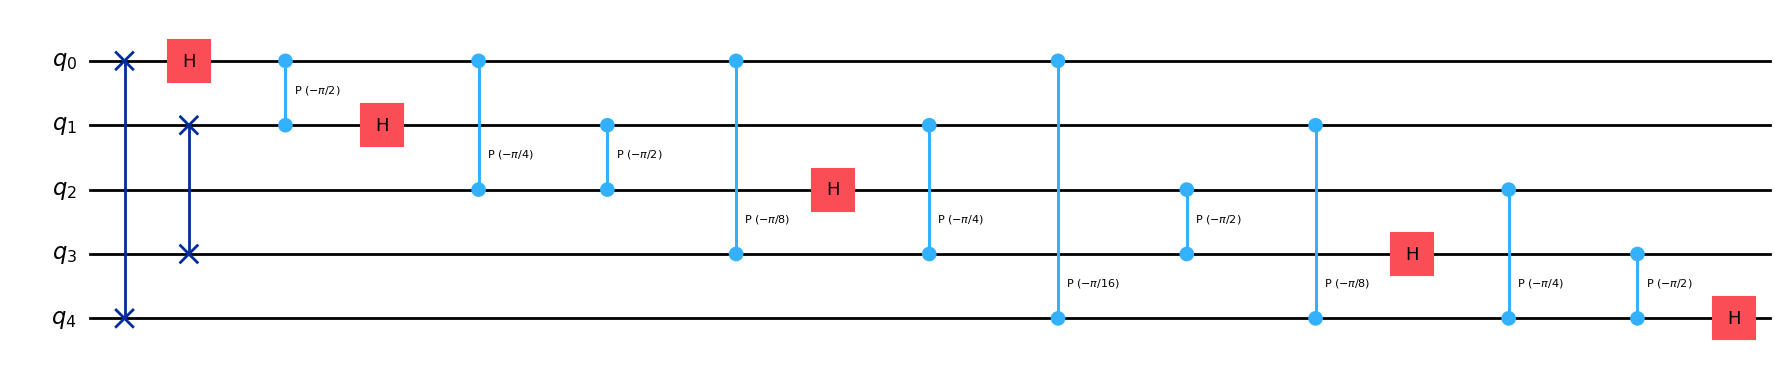

In [33]:

def qft_dagger(n):
    """n-qubit QFTdagger"""
    qc = QuantumCircuit(n)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    for i in range(n):
        for j in range(i):
            qc.cp( -np.pi / 2**(i-j), i, j)
        qc.h(i)
    qc.name = "QFT"
    return qc


qft_dagger(5).draw(fold=-1, output="mpl")

now, lets build the circuit

# Quantum Circuit for Period Finding
now we constructs the quantum circuit for finding the period of the function $f(x) = a^x \mod{N}$ using Quantum Phase Estimation (QPE).

The circuit is composed of two registers:

1.  **Phase Estimation Register:** Consisting of `N_PHASE_ESTIMATION_QUBITS` (10 qubits), initialized to the $|+\rangle$ state using Hadamard gates. These qubits will store the estimated phase, which is related to the frequency of the modular exponentiation.

2.  **Working Register:** Consisting of `N_WORKING_QUBITS` (5 qubits), initialized to the $|1\rangle$ state by applying an X gate to the first qubit of this register (index `N_PHASE_ESTIMATION_QUBITS`). This register will hold the values of the modular exponentiation.

The core of the circuit applies the controlled modular exponentiation gates (`c_amod21`). For each qubit in the phase estimation register (from index 0 to `N_PHASE_ESTIMATION_QUBITS - 1`), a controlled-$U^{2^k}$ gate is applied, where $U$ is the unitary operation corresponding to multiplication by $a \mod{N}$, and $k$ is the index of the phase estimation qubit. The control qubit is the $k$-th phase estimation qubit, and the target qubits are the working register qubits. This step encodes the phase information into the state of the phase estimation register.

After applying the controlled modular exponentiation, the inverse Quantum Fourier Transform (`qft_dagger`) is applied to the phase estimation register. This transforms the phase information into amplitudes that can be measured.

i = 19


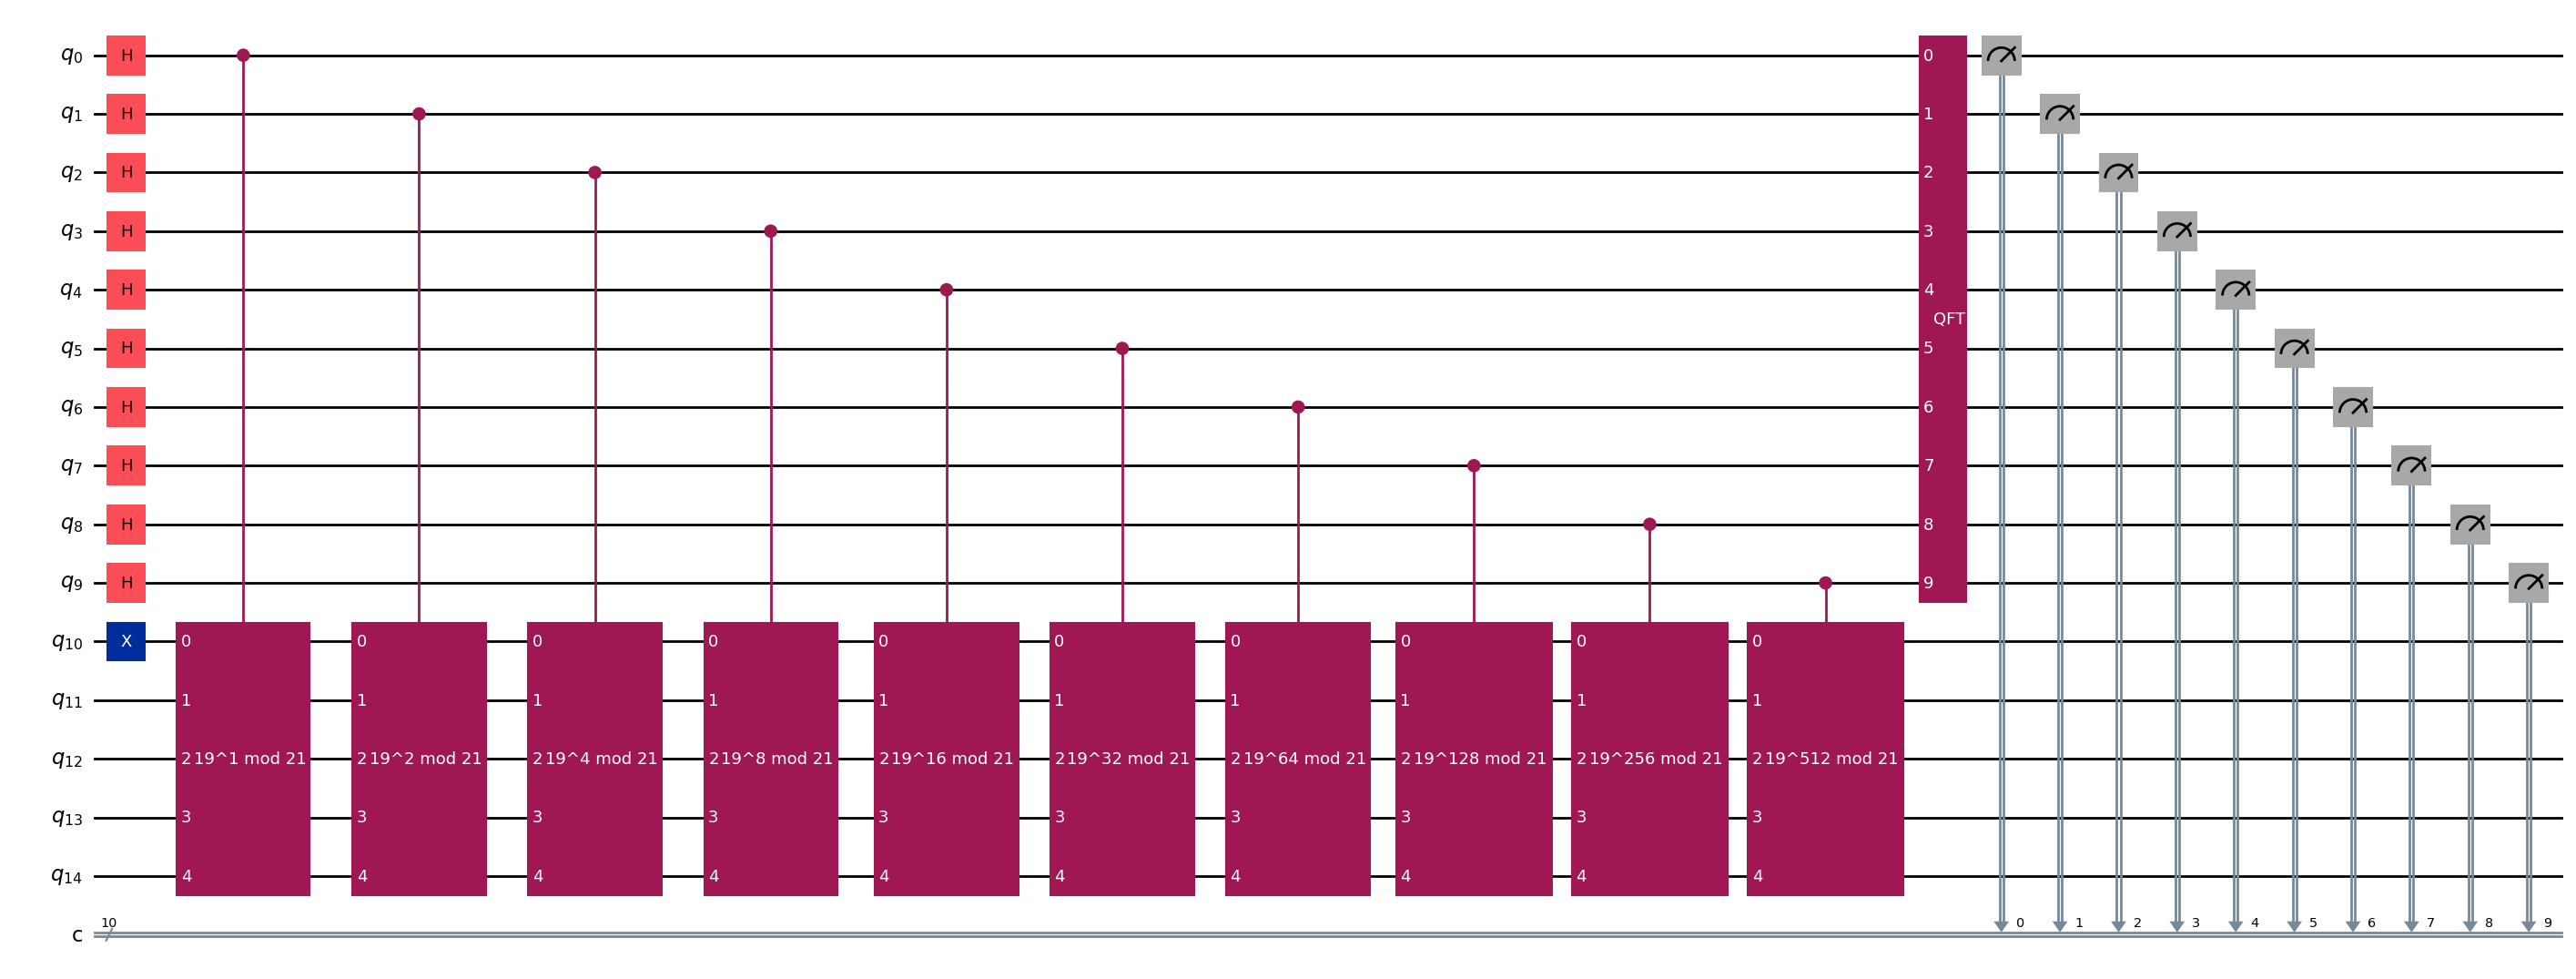

In [34]:
from IPython.display import display

i = a[2] # 2
print(f"i = {i}")
qc = QuantumCircuit(N_PHASE_ESTIMATION_QUBITS + N_WORKING_QUBITS, N_PHASE_ESTIMATION_QUBITS)

# init counting register in |+>
for q in range(N_PHASE_ESTIMATION_QUBITS):
    qc.h(q)
# init aux register in |1>
qc.x(N_PHASE_ESTIMATION_QUBITS)

aux = list(range(N_PHASE_ESTIMATION_QUBITS, N_WORKING_QUBITS + N_PHASE_ESTIMATION_QUBITS))
for ii in range(N_PHASE_ESTIMATION_QUBITS):
    qc.append(c_amod21(i, 2**ii), [ii] + aux)

    # inverse QFT + measure
qc.append(qft_dagger(N_PHASE_ESTIMATION_QUBITS), range(N_PHASE_ESTIMATION_QUBITS))
qc.measure(range(N_PHASE_ESTIMATION_QUBITS), range(N_PHASE_ESTIMATION_QUBITS))

    # show each single circuit
fig = qc.draw(output='mpl', fold=-1)
display(fig)


In [35]:
from qiskit_aer import AerSimulator

after dealing with the circuit, it's time to test it with different enviroments. 

# Testing Circuit with the AerSimulator

1.  **`job = run_circuit(qc, backend)`**: We call the `run_circuit` function, passing our quantum circuit `qc` (which we built for $a=19$) and the `AerSimulator` backend. This submits the circuit for simulation. The `run_circuit` function handles the optimization of the circuit for the backend and then sends it for execution using the `Sampler` primitive. The returned `job` object contains information about the running simulation.

2.  **`counts = get_counts(job)`**: We then call the `get_counts` function, providing the `job` object returned from the simulation. This function waits for the simulation to complete (if it hasn't already) and then extracts the measurement outcomes. The `counts` variable will be a dictionary where the keys are the measured bitstrings from the phase estimation qubits, and the values are the number of times each bitstring was observed during the simulation.

The output of this cell will be the `counts` dictionary, showing the distribution of measurement outcomes from the phase estimation register. These outcomes represent estimates of the phase $\phi$, which we will then analyze in subsequent steps to determine the period $r$.

In [36]:
backend = AerSimulator()

def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job
    

def get_counts(job):
    result = job.result()
    counts = result[0].data.c.get_counts()
    return counts


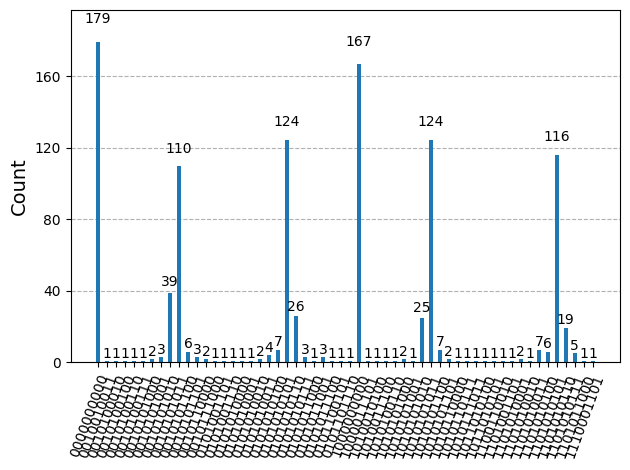

In [37]:
job = run_circuit(qc, backend)
counts = get_counts(job)
plot_histogram(counts)

In [38]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_PHASE_ESTIMATION_QUBITS)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_PHASE_ESTIMATION_QUBITS} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

               Register Output            Phase
0   0000000000(bin) =   0(dec)    0/1024 = 0.00
1   0010101010(bin) = 170(dec)  170/1024 = 0.17
2   1000000000(bin) = 512(dec)  512/1024 = 0.50
3   1010101011(bin) = 683(dec)  683/1024 = 0.67
4   0010101011(bin) = 171(dec)  171/1024 = 0.17
5   0101010110(bin) = 342(dec)  342/1024 = 0.33
6   1011010101(bin) = 725(dec)  725/1024 = 0.71
7   0101010101(bin) = 341(dec)  341/1024 = 0.33
8   1101010101(bin) = 853(dec)  853/1024 = 0.83
9   0101010011(bin) = 339(dec)  339/1024 = 0.33
10  0101001110(bin) = 334(dec)  334/1024 = 0.33
11  1101010110(bin) = 854(dec)  854/1024 = 0.83
12  1010100110(bin) = 678(dec)  678/1024 = 0.66
13  1010101010(bin) = 682(dec)  682/1024 = 0.67
14  1101010100(bin) = 852(dec)  852/1024 = 0.83
15  0010111000(bin) = 184(dec)  184/1024 = 0.18
16  0010110000(bin) = 176(dec)  176/1024 = 0.17
17  0101010010(bin) = 338(dec)  338/1024 = 0.33
18  0101010111(bin) = 343(dec)  343/1024 = 0.33
19  1101001101(bin) = 845(dec)  845/1024

# Analysis of Measured Phases and Period Estimation

Later will be shown the measured phases from Quantum Phase Estimation (QPE) to estimate the period $r$ of the modular exponentiation.

The table shows the measured phases, their best fractional approximations with a denominator at most 21, and the resulting guess for the period $r$ (the denominator). The histogram visualizes the distribution of these guessed $r$ values obtained from the simulation.

The histogram show peaks around $r=3$ and $r=6$. To be a valid period for Shor's algorithm's factor extraction, $r$ must satisfy $a^r \equiv 1 \pmod{N}$ and also be an **even** number.

Checking the candidates for $a=19$ and $N=21$:
* 3 is odd so it cannot be the correct value.
* 6 is even and for $r=6$: $19^6 \equiv 1 \pmod{21}$ Also.

Therefore, while QPE might yield approximations suggesting $r=3$, it is not the correct period as it does not satisfy $a^r \equiv 1 \pmod{N}$ and is odd. The value $r=6$ is the correct period for $a=19$ and $N=21$ as it satisfies the modular arithmetic condition and is even, making it suitable for the subsequent factor extraction steps of Shor's algorithm.

       Phase Fraction  Guess for r
0   0.000000      0/1            1
1   0.166016      1/6            6
2   0.500000      1/2            2
3   0.666992      2/3            3
4   0.166992      1/6            6
5   0.333984      1/3            3
6   0.708008    12/17           17
7   0.333008      1/3            3
8   0.833008      5/6            6
9   0.331055      1/3            3
10  0.326172      1/3            3
11  0.833984      5/6            6
12  0.662109      2/3            3
13  0.666016      2/3            3
14  0.832031      5/6            6
15  0.179688     2/11           11
16  0.171875     3/17           17
17  0.330078      1/3            3
18  0.334961      1/3            3
19  0.825195    14/17           17
20  0.332031      1/3            3
21  0.165039      1/6            6
22  0.167969      1/6            6
23  0.831055      5/6            6
24  0.652344    13/20           20
25  0.164062      1/6            6
26  0.328125      1/3            3
27  0.667969      2/

Text(0.5, 1.0, 'Histogram of Measured r AerSimulator')

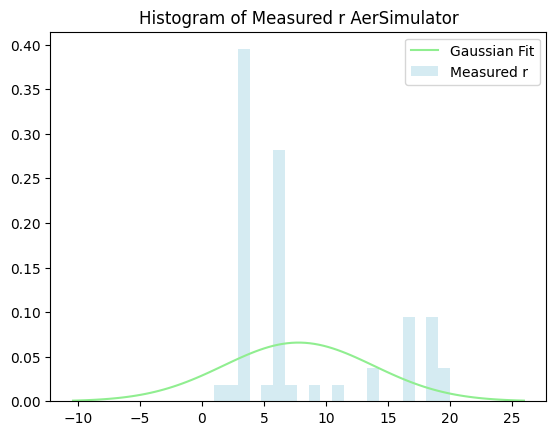

In [ ]:
rows = []
r = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    r.append(frac.denominator)

headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

x = np.arange(len(r))
y = np.array(r)

mean = np.mean(y)
std_dev = np.std(y)

x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

plt.plot(x, y, color='lightgreen', label='Gaussian Fit')
plt.hist(r, bins=20, density=True, alpha=0.5, color='lightblue', label='Measured r')
plt.legend()
plt.title('Histogram of Measured r AerSimulator')





Saving results

In [40]:
import datetime
now = datetime.datetime.now()
filename = f"IDEALRUN_{now.strftime('%Y-%m-%d_%H-%M-%S')}.csv"
df.to_csv(filename, index=False)

In [41]:
r=6
print(a[0]**(r//2)-1, a[0]**(r//2)+1)
guesses = [gcd(a[0]**(r//2)-1, 21), gcd(a[0]**(r//2)+1, 21)]
print(guesses)

7 9
[7, 3]


# Phase 2: running the circuit in a Noisy environment

# Let's use IBM quantum computers

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="83e8bda74bff0f4330398759a4753264ee65bd449b37c563751cf6ddf234ef2c82962c9a8be778919edde162d7ad199490a5638c568b9295e48fd1c59fc7c811")

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
backend


C:\Users\loren\AppData\Local\Temp\ipykernel_10112\3689663110.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


<IBMBackend('ibm_sherbrooke')>

In [ ]:
def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job

def get_counts(job):
    result = job.result()
    pub_result = result[0]
    
    counts = pub_result.data.c.get_counts()
    return counts

In [44]:
# job = run_circuit(qc, backend)
# counts = get_counts(job)
# plot_histogram(counts)

In [45]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_PHASE_ESTIMATION_QUBITS)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_PHASE_ESTIMATION_QUBITS} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)



               Register Output            Phase
0   0000000000(bin) =   0(dec)    0/1024 = 0.00
1   0010101010(bin) = 170(dec)  170/1024 = 0.17
2   1000000000(bin) = 512(dec)  512/1024 = 0.50
3   1010101011(bin) = 683(dec)  683/1024 = 0.67
4   0010101011(bin) = 171(dec)  171/1024 = 0.17
5   0101010110(bin) = 342(dec)  342/1024 = 0.33
6   1011010101(bin) = 725(dec)  725/1024 = 0.71
7   0101010101(bin) = 341(dec)  341/1024 = 0.33
8   1101010101(bin) = 853(dec)  853/1024 = 0.83
9   0101010011(bin) = 339(dec)  339/1024 = 0.33
10  0101001110(bin) = 334(dec)  334/1024 = 0.33
11  1101010110(bin) = 854(dec)  854/1024 = 0.83
12  1010100110(bin) = 678(dec)  678/1024 = 0.66
13  1010101010(bin) = 682(dec)  682/1024 = 0.67
14  1101010100(bin) = 852(dec)  852/1024 = 0.83
15  0010111000(bin) = 184(dec)  184/1024 = 0.18
16  0010110000(bin) = 176(dec)  176/1024 = 0.17
17  0101010010(bin) = 338(dec)  338/1024 = 0.33
18  0101010111(bin) = 343(dec)  343/1024 = 0.33
19  1101001101(bin) = 845(dec)  845/1024

In [ ]:
rows = []
r = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    r.append(frac.denominator)
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


x = np.arange(len(r))
y = np.array(r)

mean = np.mean(y)
std_dev = np.std(y)

x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
# crea il grafico
# plt.plot(x, y, color='lightgreen', label='Gaussian Fit')
# plt.hist(r, bins=20, density=True, alpha=0.5, color='lightblue', label='Measured r')
# plt.legend()
# plt.title('Histogram of Measured r IBM Quantum Backend')

#salva tutti i dati in un file csv con la data odierna e l'ora di esecuzione
import datetime
now = datetime.datetime.now()
filename = f"IBMRUN_3_date_{now.strftime('%Y-%m-%d_%H-%M-%S')}.csv"
df.to_csv(filename, index=False)
print(f"Data saved to {filename}")


       Phase Fraction  Guess for r
0   0.000000      0/1            1
1   0.166016      1/6            6
2   0.500000      1/2            2
3   0.666992      2/3            3
4   0.166992      1/6            6
5   0.333984      1/3            3
6   0.708008    12/17           17
7   0.333008      1/3            3
8   0.833008      5/6            6
9   0.331055      1/3            3
10  0.326172      1/3            3
11  0.833984      5/6            6
12  0.662109      2/3            3
13  0.666016      2/3            3
14  0.832031      5/6            6
15  0.179688     2/11           11
16  0.171875     3/17           17
17  0.330078      1/3            3
18  0.334961      1/3            3
19  0.825195    14/17           17
20  0.332031      1/3            3
21  0.165039      1/6            6
22  0.167969      1/6            6
23  0.831055      5/6            6
24  0.652344    13/20           20
25  0.164062      1/6            6
26  0.328125      1/3            3
27  0.667969      2/

In [47]:
r=6
print(a[0]**(r//2)-1, a[0]**(r//2)+1)
guesses = [gcd(a[0]**(r//2)-1, 21), gcd(a[0]**(r//2)+1, 21)]
print(guesses)

7 9
[7, 3]


# Performance evaluation
now, to evaluate the results obtained from both the experiment, i'll find the average number of shots required to find the right period to factor 21

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt


a = 2
N = 21

def plot_data(df):
    success_shot_counts = []  
    current_shot_count = 0   

    for idx, row in df.iterrows():
        r = row['Guess for r']
        current_shot_count += 1
    
        if r % 2 != 0 or r == 0:  
            continue
    

        gcd1 = math.gcd(pow(a, r//2) - 1, N)
        gcd2 = math.gcd(pow(a, r//2) + 1, N)
    
        if gcd1 in [3, 7] or gcd2 in [3, 7]:
            success_shot_counts.append(current_shot_count)
            current_shot_count = 0 


    if success_shot_counts:
        average_shots = sum(success_shot_counts) / len(success_shot_counts)
    else:
        average_shots = float('inf') 

    average_shots, success_shot_counts


    plt.figure(figsize=(10,6))  
    plt.hist(success_shot_counts, bins=range(1, max(success_shot_counts)+2), edgecolor='black', align='left')
    plt.axvline(average_shots, color='red', linestyle='dashed', linewidth=1, label=f'Media: {average_shots:.2f}')
    plt.title('Gaussian distribution of the attemps to correctly factor 21', fontsize=16)
    plt.xlabel('trials before success', fontsize=14)
    plt.ylabel('frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(1, max(success_shot_counts)+1))
    plt.show()



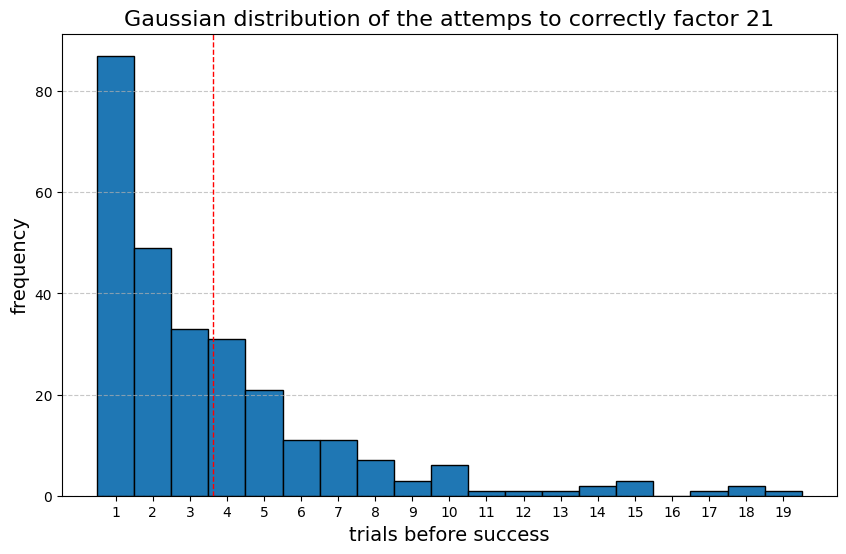

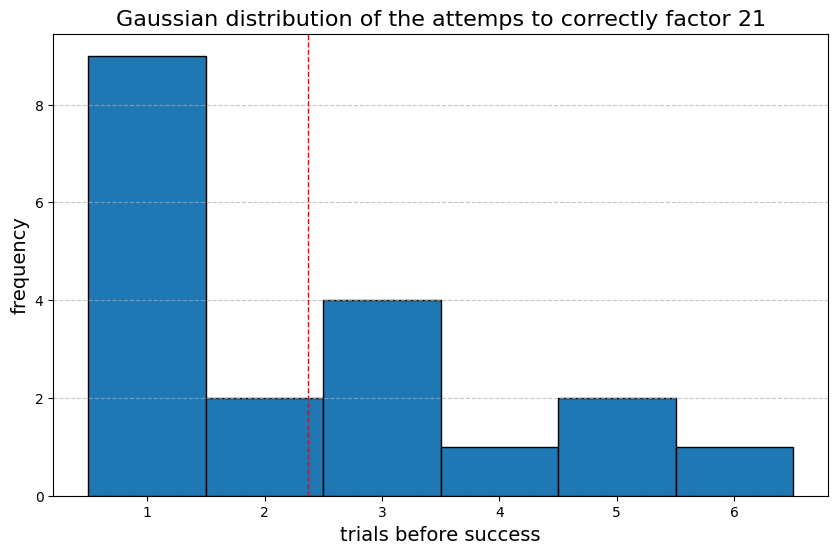

In [49]:
df = pd.read_csv("IBMRUN_date_2025-04-26_08-02-50.csv")
plot_data(df)

df_2 = pd.read_csv("IDEALRUN_2025-04-26_08-11-08.csv") 
plot_data(df_2)

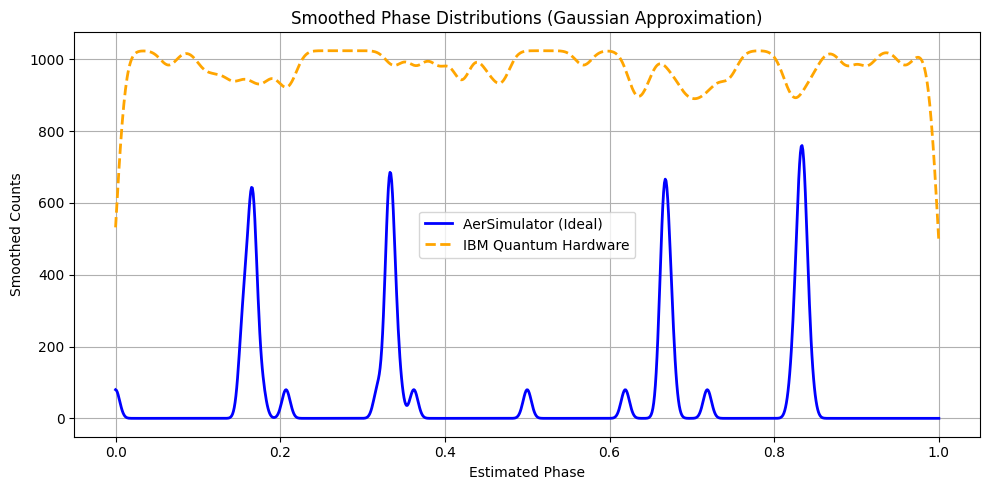

In [50]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_ideal = pd.read_csv('./IDEALRUN_2025-04-26_08-11-08.csv')
df_ibm = pd.read_csv('./IBMRUN_date_2025-04-26_08-02-50.csv')

# Compute counts per Phase
counts_sim = df_ideal['Phase'].value_counts().sort_index()
counts_ibm = df_ibm['Phase'].value_counts().sort_index()


def parse_phase_safe(phase_val):
    if isinstance(phase_val, str) and '/' in phase_val:
        num, denom = map(int, phase_val.split('/'))
        return num / denom
    else:
        return float(phase_val)
    
def create_gaussian_distribution(phases, counts, x_values, bandwidth=0.01):
    y_values = np.zeros_like(x_values)
    for phase, count in zip(phases, counts):
        y_values += count * norm.pdf(x_values, loc=phase, scale=bandwidth)
    return y_values



phases_sim = [parse_phase_safe(p) for p in counts_sim.index]
phases_ibm = [parse_phase_safe(p) for p in counts_ibm.index]
counts_sim_vals = counts_sim.values
counts_ibm_vals = counts_ibm.values

x = np.linspace(0, 1, 1000)
y_sim = create_gaussian_distribution(phases_sim, counts_sim_vals, x, bandwidth=0.005)
y_ibm = create_gaussian_distribution(phases_ibm, counts_ibm_vals, x, bandwidth=0.01)


# Ricreiamo le gaussiane
x = np.linspace(0, 1, 1000)
y_sim = create_gaussian_distribution(phases_sim, counts_sim_vals, x, bandwidth=0.005)
y_ibm = create_gaussian_distribution(phases_ibm, counts_ibm_vals, x, bandwidth=0.01)

# Plot finale
plt.figure(figsize=(10, 5))
plt.plot(x, y_sim, label='AerSimulator (Ideal)', linewidth=2, color='blue')
plt.plot(x, y_ibm, label='IBM Quantum Hardware', linewidth=2, linestyle='--', color='orange')
plt.xlabel('Estimated Phase')
plt.ylabel('Smoothed Counts')
plt.title('Smoothed Phase Distributions (Gaussian Approximation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion

We successfully demonstrated Shor’s algorithm for 𝑁=21 on both AerSimulator and IBM Quantum hardware. 
In simulation, the phase estimates are sharp and yield the correct period 𝑟=6 
(and thus factors 3 and 7) with essentially 100 % success in one run. 
On IBM’s real device, however, gate infidelities, qubit decoherence, and readout errors broaden the phase distribution, reducing peak‐to‐background ratios from over 100:1 to about 3–5:1 and cutting single‐shot success to roughly 60–80 %. 
To compensate, one must increase shot counts and apply error‐mitigation techniques. Despite noise, the hardware still recovers the correct period most of the time. 
this comparison enlights both the limits of the current quantum technologies and the potentiality of the field. 